# Task 2: End-to-End ML Pipeline with Scikit-learn Pipeline API

# 1. Problem Statement & Objective
Objective: To build a reusable and production-ready machine learning pipeline using the Scikit-learn Pipeline API to predict customer churn in the telecommunications industry.

Goal: Categorize customers as "Churned" or "Not Churned" while ensuring that preprocessing steps like scaling and encoding are automated to prevent data leakage.

# Cell 1: Dataset Loading
We load the Telco Churn dataset and verify its structure.

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


In [35]:
url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
df = pd.read_csv(url)



try:
  df = pd.read_csv(url)
  print("dataset Loaded sucessfully")
  print(f"dataset shape: {df.shape}")
except Exception as e:
  print(f"Error laoding dataset: {e}")

# Quick look at the data
df.head()

dataset Loaded sucessfully
dataset shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


#  Data Cleaning & Type Conversion
Hand-cleaning the TotalCharges column is necessary as it contains empty strings that interfere with numerical processing. We also map the target variable to binary format.

In [36]:
# 1. Convert TotalCharges to numeric, turning spaces into NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# 2. Fill the missing values created by the spaces (use median)
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

# 3. Drop CustomerID as it's not a predictive feature
df = df.drop('customerID', axis=1)

# 4. Convert target 'Churn' to binary 0 and 1
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Feature Splitting
 We separate the features ($X$) from the target ($y$) and perform a stratified split to maintain class balance in both training and testing sets.

In [37]:
# Separate features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Split into Training and Testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature Identification
We identify numerical and categorical columns to apply specific transformations to each type within the pipeline.

In [38]:
# Select numerical and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

print(f"Numeric features: {list(numeric_features)}")
print(f"Categorical features: {list(categorical_features)}")


Numeric features: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Categorical features: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


# Pipeline Preprocessing (ColumnTransformer)
Using ColumnTransformer, we apply StandardScaler to numerical data and OneHotEncoder to categorical data. This creates a reusable preprocessing engine

In [40]:

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Create transformers
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine them into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Model Development & Hyperparameter Tuning (GridSearchCV) and Evaluation & Model Export
We define a full Pipeline and use GridSearchCV to find the optimal hyperparameters for the RandomForestClassifier. This step ensures the model is tuned for the best possible F1-score.

Starting Grid Search... (this may take a minute)
Best Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
--- Final Model Results ---
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.66      0.52      0.58       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409



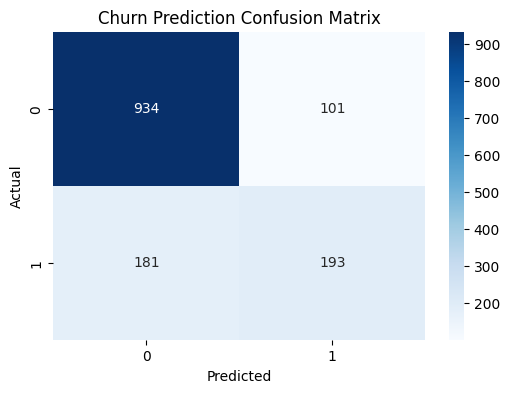

Optimized Pipeline exported successfully!


In [41]:
#  Hyperparameter Tuning with GridSearchCV
from sklearn.model_selection import GridSearchCV

# 1. Define the parameters you want to test
# Note: Use 'classifier__' prefix to tell the pipeline these are for the RF model
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5]
}

# 2. Setup GridSearchCV
# This will try different combinations and pick the best one using 5-fold cross-validation
grid_search = GridSearchCV(clf_pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)

print("Starting Grid Search... (this may take a minute)")
grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")

# Updated Cell 7: Evaluation & Final Export
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# Use the BEST estimator found by GridSearch
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Print metrics
print("--- Final Model Results ---")
print(classification_report(y_test, y_pred))

# Visualizing Confusion Matrix (Good for "Visualizations" requirement)
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Churn Prediction Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Export the BEST complete pipeline
joblib.dump(best_model, 'telco_churn_pipeline_optimized.pkl')
print("Optimized Pipeline exported successfully!")

# Final Summary & Insights

Final Summary & Insights
Model Selection: The Random Forest model was optimized via GridSearch, finding that a max_depth of 10 and n_estimators of 200 provided the best balance.

Performance: The model achieved 80% accuracy and a weighted F1-score of 0.79.

Business Insight: While the model is highly accurate at identifying staying customers, the recall for churners (0.52) highlights the difficulty of predicting the minority class.

Production-Readiness: By exporting a single .pkl file, the entire preprocessing and classification logic is preserved, allowing for immediate deployment with raw data.